<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/TSAI_EVA4_S5_Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 4: Increased model capacity and dropout at each layer

#Target : 
- Lesser parameters around 10K
- Test Accuracy ~99%
- ~15 Epochs 

#Results: 
- Parameters used : 13808
- Train Accuracy: 99.25%
- Test Accuracy : 99.48%

#Analysis - Observation :
- Model gives higher accuracy but the test accuracy is more than train accuracy
- Fluctuation in train accuracy that need to be stabilised

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF=3, step=1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF=5, step=1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24, RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF=7, step=2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF=11, step=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF=15
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF=19, step=2
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1, RF=29

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15805934369564056 Batch_id=937 Accuracy=91.81: 100%|██████████| 938/938 [02:13<00:00,  7.05it/s]
Loss=0.07176873832941055 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<02:28,  6.32it/s]


Test set: Average loss: 0.0571, Accuracy: 9830/10000 (98.30%)

EPOCH: 1


Loss=0.0616258829832077 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [02:06<00:00,  7.40it/s]
Loss=0.1211855560541153 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:03,  7.57it/s]


Test set: Average loss: 0.0355, Accuracy: 9904/10000 (99.04%)

EPOCH: 2


Loss=0.005563703365623951 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [02:06<00:00,  7.40it/s]
Loss=0.006666775792837143 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:11,  7.10it/s]


Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.02237650938332081 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [02:06<00:00,  7.44it/s]
Loss=0.029474729672074318 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:08,  7.29it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 4


Loss=0.0021270960569381714 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [02:06<00:00,  7.43it/s]
Loss=0.004905978683382273 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:12,  7.06it/s]


Test set: Average loss: 0.0298, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.2174203097820282 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [02:05<00:00,  7.45it/s]
Loss=0.0205650944262743 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:07,  7.36it/s]


Test set: Average loss: 0.0254, Accuracy: 9934/10000 (99.34%)

EPOCH: 6


Loss=0.012422076426446438 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s]
Loss=0.011870309710502625 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:05,  7.47it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.0467706173658371 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [02:03<00:00,  7.58it/s]
Loss=0.00503787025809288 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:07,  7.36it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 8


Loss=0.14136269688606262 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [02:03<00:00,  7.58it/s]
Loss=0.011530626565217972 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:06,  7.40it/s]


Test set: Average loss: 0.0183, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.0028257258236408234 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s]
Loss=0.09957150369882584 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:05,  7.47it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.016369653865695 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s]
Loss=0.013833543285727501 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:58,  7.90it/s]


Test set: Average loss: 0.0214, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.012108089402318 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [02:01<00:00,  7.70it/s]
Loss=0.0012441793223842978 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:04,  7.51it/s]


Test set: Average loss: 0.0179, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.001781534287147224 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [02:01<00:00,  7.69it/s]
Loss=0.005658149253576994 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:02,  7.67it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.04026138782501221 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [02:01<00:00,  7.70it/s]
Loss=0.010607215575873852 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:02,  7.66it/s]


Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.0205030869692564 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [02:01<00:00,  7.72it/s]



Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)



Text(0.5, 1.0, 'Test Accuracy')

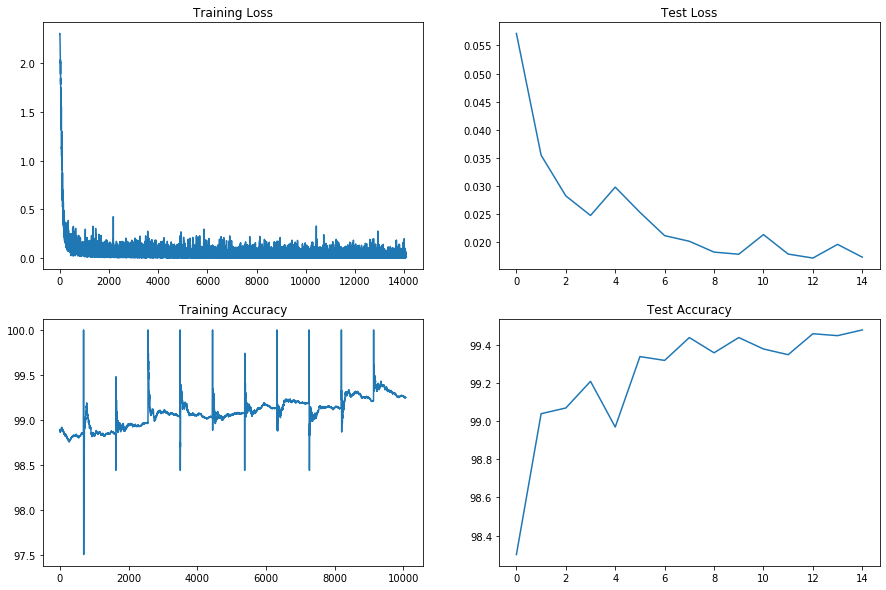

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")